In [1]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from albumentations.pytorch import ToTensorV2
from torch.autograd import Variable


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"""
#  To get unique colors in RGB masked image

l=[]

for i in range(4864):
       for j in range(20480):
            for s in list(img[i][j]):
              if s not in l:
                l.append(s)
"""

'\n#  To get unique colors in RGB masked image\n\nl=[]\n\nfor i in range(4864):\n       for j in range(20480):\n            for s in list(img[i][j]):\n              if s not in l:\n                l.append(s)\n'

In [3]:
COLORMAP = [
        [0, 0, 0],
        [255, 255, 0],
        [150, 150, 150],
        [0, 255, 0],
        [0, 0, 255],
        [0, 150, 255] 
    ]

CLASSES = [
        'background',
        'yellow',
        'grey',
        'green',
        'blue',
        'red'
    ]


In [4]:
def set_seed(seed = 0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed()

In [6]:
#train_transform = A.Compose([
#    #A.Resize(width=128, height=128, p=1.0),
#    A.HorizontalFlip(p=0.5),
#    A.VerticalFlip(p=0.5),
#    A.RandomRotate90(p=0.5),
#    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
#])

In [5]:
class BiopseDataset(data.Dataset):
    """ Dataset class for Biopse Dataset """
    def __init__(self, dir_path, colormap, transform=None):
        self.dir_path = dir_path
        self.transforms = transform
        self.img_dir=os.path.join(dir_path,"images")
        self.mask_dir=os.path.join(dir_path,"masks")
        self.images=os.listdir(self.img_dir)
        self.masks=os.listdir(self.mask_dir)
        self.colormap=colormap

    def process_mask(self, rgb_mask):
         output_mask = []
         for i, color in enumerate(self.colormap):
             cmap = np.all(np.equal(rgb_mask, color), axis=-1)
             #print(np.equal(rgb_mask, color).shape)

             output_mask.append(cmap)
         #print(len(output_mask))
         output_mask = np.argmax(output_mask, axis=0)
         #print(output_mask.shape)
         
         #print(np.unique(output_mask))
         #print(output_mask)

         return output_mask

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img = np.array(Image.open(os.path.join(self.img_dir,self.images[index])))
        img=img/255.0
        mask = np.array(Image.open(os.path.join(self.mask_dir, "mask_"+self.images[index])))#      self.masks[index])))
        if self.transforms is not None:
            mask = self.process_mask(mask)
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            #mask = self.process_mask(mask) #torch.max(mask,dim=2)[0]
        return img,mask

In [6]:
t1 = A.Compose([
    #A.Resize(160,240),
    #A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [7]:
def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = BiopseDataset(image_dir,COLORMAP,transform = transform)
    train_size = int(0.8 * data.__len__())  # keeping train/test ratio 80%/20%
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory) # train dataloader
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory) # test dataloader
    return train_batch,test_batch

In [8]:
train_batch,test_batch = get_images("/content/drive/MyDrive/patchedData",transform =t1,batch_size=4)


In [11]:
#for img,mask in train_batch:
#    mask1 = np.array(mask[0,:,:])
#    print(np.unique(mask1))
#    print(mask1.shape)

torch.float64


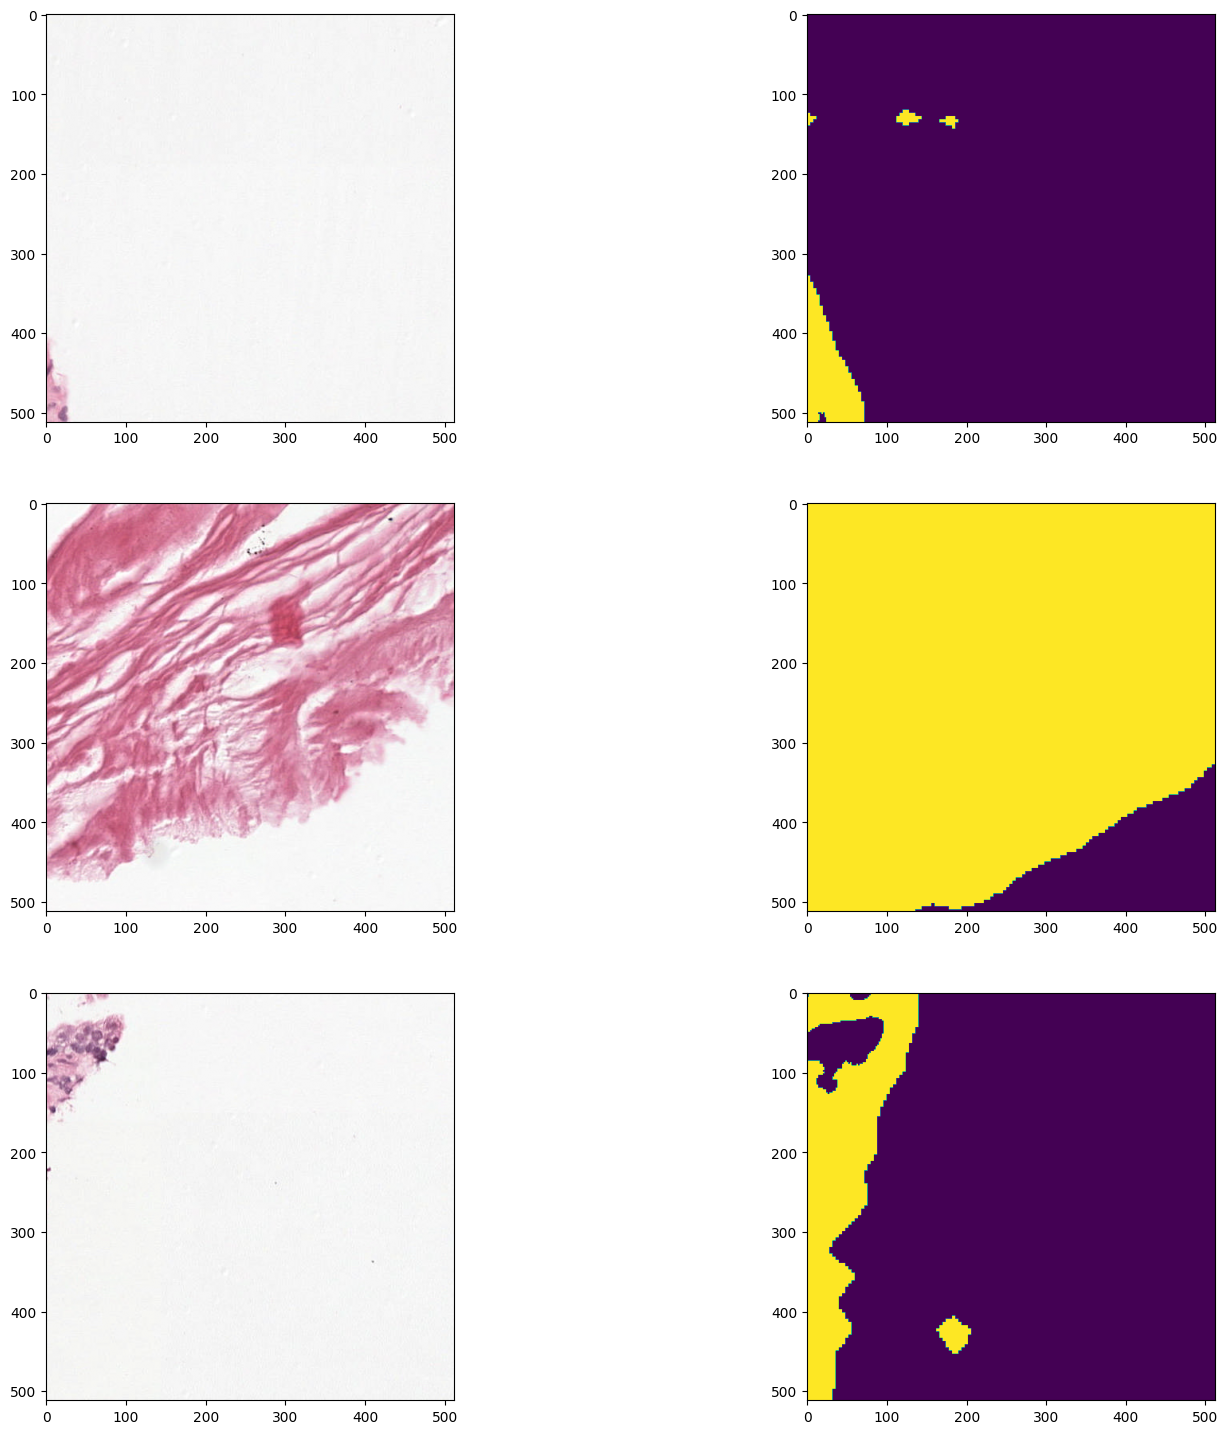

In [9]:
for img,mask in train_batch:
    print(img[0].dtype)
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [10]:
!pip install torchsummary 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)    

In [12]:
class unet_model(nn.Module):
    def __init__(self,out_channels=6,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [13]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [14]:
model = unet_model().to(DEVICE)


In [18]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [15]:
LEARNING_RATE = 1e-4
num_epochs = 8

In [16]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [17]:
def dice_loss(true, logits, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes).to(DEVICE)
        true_1_hot=true_1_hot[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [18]:
class_weights=torch.tensor([0.5, 0.7, 0.7, 0.9, 0.9, 0.9],dtype=torch.float).to(DEVICE)

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
dice_loss_fn=dice_loss

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [19]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")


In [20]:
def compute_val_loss(test_batch, model):
    model.eval()
    for batch_idx, (data, targets) in enumerate(test_batch):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data.float())
            loss = ce_loss_fn(predictions, targets)#+dice_loss_fn(targets, predictions)
    model.train()
    return loss


In [ ]:
min_loss=10000
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        #print(data.shape)
        #print(data[0])
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data.float())
            #break
            loss = ce_loss_fn(predictions, targets)#+dice_loss_fn(targets, predictions)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        if batch_idx % 50 == 0:
              val_loss=compute_val_loss(test_batch, model)
              print ("Train loss"+ str(loss.item())+ " Val loss :"+ 
                     str(val_loss.item()))
              writer.add_scalar("train loss", loss.item(),epoch)
              writer.add_scalar("validation loss", val_loss.item(),epoch)
        loop.set_postfix(loss=loss.item())
        
    


    if loss < min_loss:
        min_loss=loss
        print("saving min loss at epoch"+ str(epoch))
        torch.save(model, "/content/drive/MyDrive/biopseModel.pth")
writer.close()


  1%|          | 1/162 [01:01<2:46:10, 61.93s/it, loss=1.81]

Train loss1.8147574663162231 Val loss :1.7835049629211426


 31%|███▏      | 51/162 [02:24<10:17,  5.57s/it, loss=1.04]

Train loss1.0375388860702515 Val loss :1.2060399055480957


 62%|██████▏   | 101/162 [03:45<05:11,  5.10s/it, loss=1.03]

Train loss1.026932716369629 Val loss :1.2874155044555664


 93%|█████████▎| 151/162 [05:05<00:55,  5.02s/it, loss=0.83]

Train loss0.8303244113922119 Val loss :0.7251352667808533


100%|██████████| 162/162 [05:21<00:00,  1.98s/it, loss=1.1]


saving min loss at epoch0


  1%|          | 1/162 [00:14<37:36, 14.01s/it, loss=0.693]

Train loss0.6930584907531738 Val loss :1.465172529220581


 31%|███▏      | 51/162 [01:02<08:36,  4.65s/it, loss=0.809]

Train loss0.8090513348579407 Val loss :0.8575412034988403


 62%|██████▏   | 101/162 [01:52<04:50,  4.77s/it, loss=0.791]

Train loss0.7912987470626831 Val loss :1.2158515453338623


 93%|█████████▎| 151/162 [02:40<00:47,  4.33s/it, loss=0.886]

Train loss0.8864484429359436 Val loss :0.8212941288948059


100%|██████████| 162/162 [02:48<00:00,  1.04s/it, loss=1.03]


saving min loss at epoch1


  1%|          | 1/162 [00:13<37:24, 13.94s/it, loss=0.682]

Train loss0.6815695762634277 Val loss :0.49558478593826294


 31%|███▏      | 51/162 [01:02<08:26,  4.56s/it, loss=0.676]

Train loss0.6759688258171082 Val loss :0.9443318843841553


 62%|██████▏   | 101/162 [01:50<04:34,  4.50s/it, loss=1.11]

Train loss1.1148993968963623 Val loss :0.727616548538208


 93%|█████████▎| 151/162 [02:38<00:48,  4.41s/it, loss=0.701]

Train loss0.7009457349777222 Val loss :1.1445008516311646


100%|██████████| 162/162 [02:45<00:00,  1.02s/it, loss=0.755]


saving min loss at epoch2


  1%|          | 1/162 [00:13<37:06, 13.83s/it, loss=0.618]

Train loss0.6184921860694885 Val loss :0.6112062931060791


 31%|███▏      | 51/162 [01:03<08:47,  4.75s/it, loss=0.756]

Train loss0.7555437088012695 Val loss :0.6875666975975037


 62%|██████▏   | 101/162 [01:54<05:02,  4.95s/it, loss=0.674]

Train loss0.67437344789505 Val loss :1.1240942478179932


 93%|█████████▎| 151/162 [02:44<00:51,  4.73s/it, loss=0.52]

Train loss0.520076334476471 Val loss :0.38845178484916687


100%|██████████| 162/162 [02:52<00:00,  1.07s/it, loss=0.568]


saving min loss at epoch3


  1%|          | 1/162 [00:14<39:02, 14.55s/it, loss=0.524]

Train loss0.5238995552062988 Val loss :0.7706974744796753


 31%|███▏      | 51/162 [01:02<08:23,  4.53s/it, loss=0.711]

Train loss0.7109858989715576 Val loss :0.3985663950443268


 62%|██████▏   | 101/162 [01:50<04:38,  4.56s/it, loss=0.386]

Train loss0.3859764337539673 Val loss :0.5744509100914001


 93%|█████████▎| 151/162 [02:38<00:50,  4.55s/it, loss=0.694]

Train loss0.6941607594490051 Val loss :0.5864831209182739


  1%|          | 1/162 [00:13<37:21, 13.92s/it, loss=0.535]

Train loss0.5347535610198975 Val loss :0.5869492292404175


 31%|███▏      | 51/162 [01:03<09:09,  4.95s/it, loss=0.731]

Train loss0.7306555509567261 Val loss :0.5334464907646179


 62%|██████▏   | 101/162 [01:54<04:39,  4.58s/it, loss=0.664]

Train loss0.6638224124908447 Val loss :1.2191417217254639


 93%|█████████▎| 151/162 [02:41<00:47,  4.36s/it, loss=0.513]

Train loss0.5133634805679321 Val loss :1.01826012134552


100%|██████████| 162/162 [02:49<00:00,  1.05s/it, loss=0.531]


saving min loss at epoch5


  1%|          | 1/162 [00:13<36:20, 13.54s/it, loss=0.562]

Train loss0.5618958473205566 Val loss :0.7248125076293945


 31%|███▏      | 51/162 [01:00<08:09,  4.41s/it, loss=0.442]

Train loss0.44247254729270935 Val loss :0.5961982011795044


 62%|██████▏   | 101/162 [01:49<04:36,  4.53s/it, loss=1.02]

Train loss1.0190544128417969 Val loss :0.40550604462623596


 93%|█████████▎| 151/162 [02:37<00:51,  4.64s/it, loss=0.475]

Train loss0.4754224717617035 Val loss :0.2499694973230362


  1%|          | 1/162 [00:14<38:19, 14.28s/it, loss=0.493]

Train loss0.49333980679512024 Val loss :0.49608683586120605


 31%|███▏      | 51/162 [01:04<08:53,  4.80s/it, loss=0.332]

Train loss0.3323279321193695 Val loss :0.5053026676177979


 62%|██████▏   | 101/162 [01:52<04:31,  4.45s/it, loss=0.49]

Train loss0.4903206527233124 Val loss :0.5055920481681824


 93%|█████████▎| 150/162 [02:27<00:08,  1.41it/s, loss=0.422]

In [22]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x.float())),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()


In [23]:
check_accuracy(train_batch, model)

Got 141169766/169869312 with acc 83.10
Dice score: 1.7553786039352417


In [24]:
check_accuracy(test_batch, model)

Got 34781253/42467328 with acc 81.90
Dice score: 1.7318295240402222


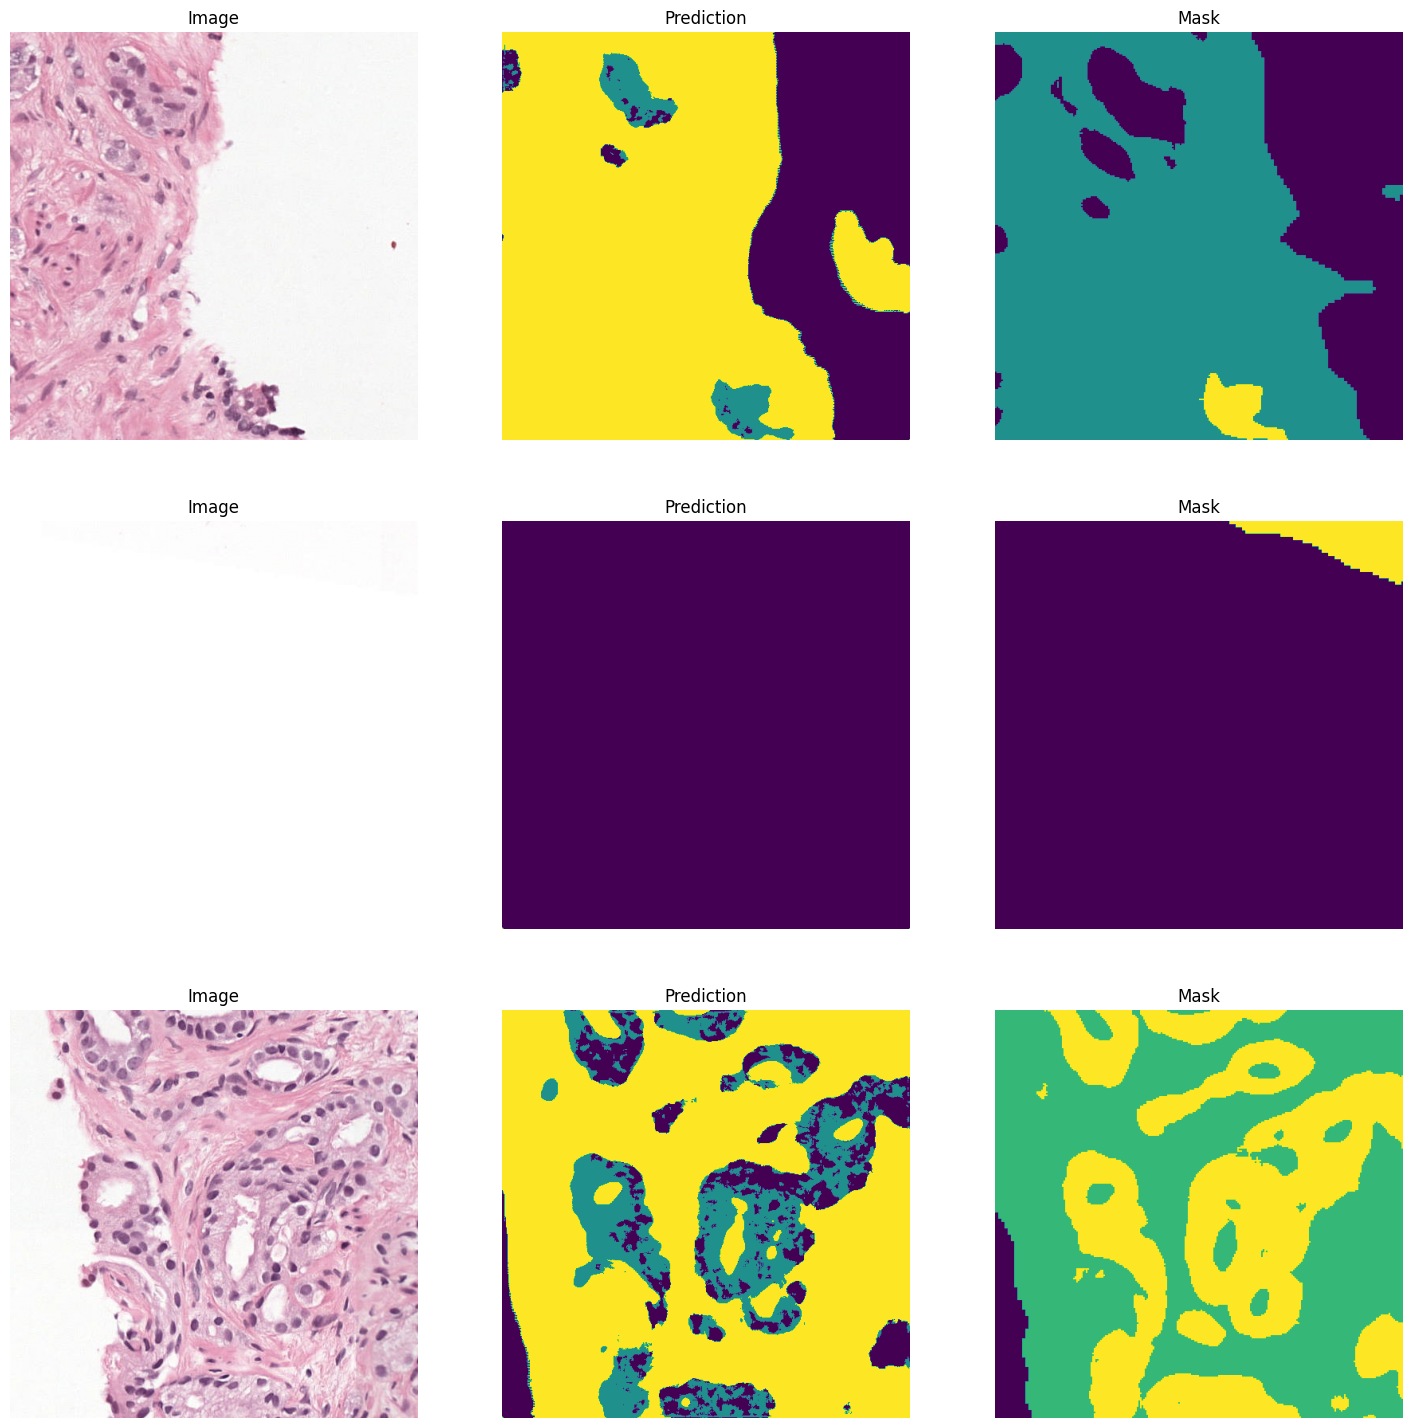

In [25]:
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x.float())),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break

In [ ]:
#model = torch.load("/content/drive/MyDrive/biopseModel.pth")
model = unet_model().to(DEVICE)
model=torch.load("/content/drive/MyDrive/biopseModel.pth", map_location=DEVICE)

model.eval()

In [ ]:
def image_loader(image_name):
 
    image = Image.open(image_name)
    image = np.array(Image.open(image_name))
    image=image/255.0
    image = t1(image=image)["image"].to(DEVICE)
    image = image.unsqueeze(0) 
    return image

In [ ]:
softmax = nn.Softmax(dim=1)
x=image_loader("/content/drive/MyDrive/BiopseDataValidation/images/patch_125.png")
prediction = torch.argmax(softmax(model(x.float())),axis=1).to(DEVICE)



In [ ]:
prediction